<a href="https://colab.research.google.com/github/VishwasMore/face-detection/blob/main/Face_Detection_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Facial Keypoint Detection 

## Load and Visualize Data

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [2]:
key_pts_frame = pd.read_csv('drive/My Drive/face/data/training_frames_keypoints.csv')

n = 0

image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts.shape)

(136,)


In [3]:
key_pts = key_pts.astype('float').reshape(-1, 2)
print(key_pts.shape)

(68, 2)


In [4]:
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [5]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


### Visualize some images

In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [7]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts)

[45.0 98.0 47.0 106.0 49.0 110.0 53.0 119.0 56.0 125.0 62.0 130.0 66.0
 134.0 73.0 136.0 81.0 139.0 92.0 134.0 96.0 130.0 98.0 126.0 102.0 120.0
 102.0 111.0 104.0 105.0 104.0 99.0 102.0 90.0 51.0 89.0 56.0 87.0 60.0
 87.0 64.0 87.0 68.0 87.0 83.0 85.0 87.0 83.0 92.0 81.0 96.0 81.0 100.0
 84.0 77.0 92.0 79.0 98.0 79.0 102.0 79.0 107.0 73.0 109.0 75.0 109.0 79.0
 111.0 81.0 109.0 83.0 109.0 58.0 94.0 62.0 92.0 64.0 92.0 68.0 92.0 66.0
 94.0 62.0 94.0 85.0 92.0 87.0 90.0 92.0 90.0 94.0 90.0 92.0 92.0 87.0
 92.0 68.0 119.0 73.0 117.0 77.0 115.0 79.0 117.0 81.0 115.0 85.0 117.0
 90.0 117.0 87.0 122.0 85.0 124.0 81.0 124.0 77.0 124.0 73.0 121.0 70.0
 119.0 77.0 119.0 79.0 119.0 83.0 119.0 90.0 117.0 83.0 119.0 81.0 122.0
 77.0 122.0]


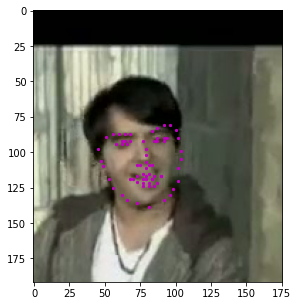

In [8]:
key_pts = key_pts.astype('float').reshape(-1,2)
plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('drive/My Drive/face/data/training/', image_name)), key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.

In [9]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
  """Face Landmarks dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    """
    Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.key_pts_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.key_pts_frame)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.root_dir, 
                              self.key_pts_frame.iloc[idx, 0])
    
    image = mpimg.imread(image_name)

    # if image has an alpha color channel, get rid of it
    if(image.shape[2] == 4):
            image = image[:,:,0:3]
    
    key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
    key_pts = key_pts.astype('float').reshape(-1, 2)
    sample = {'image': image, 'keypoints': key_pts}
    
    if self.transform:
            sample = self.transform(sample)
    
    return sample

In [10]:
# Now that we've defined this class, let's instantiate the dataset and display some images.

face_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/training_frames_keypoints.csv',
                                      root_dir='drive/My Drive/face/data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (319, 254, 3) (68, 2)
1 (240, 224, 3) (68, 2)
2 (155, 157, 3) (68, 2)


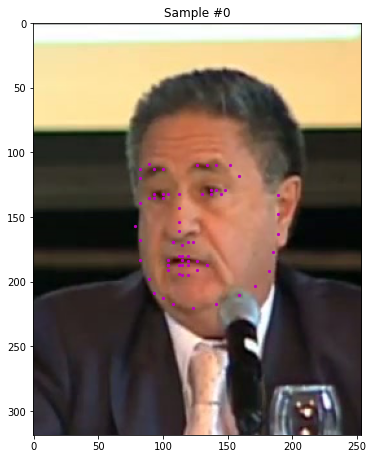

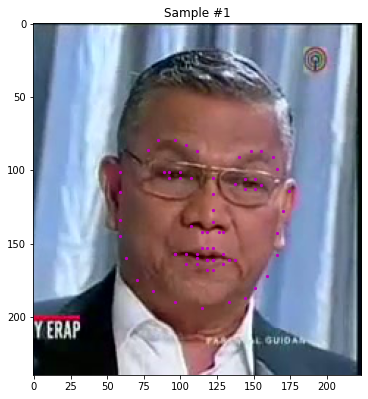

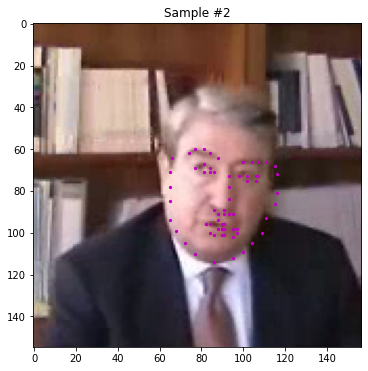

In [11]:
# Display few images of the dataset 

num_to_display = 3

for i in range(num_to_display):

  # define the size of image 
  fig = plt.figure(figsize=(20,10))

  # randomly select a sample
  rand_i = np.random.randint(0, len(face_dataset))
  sample = face_dataset[rand_i]

  # print the shape of the image and keypoints 
  print(i, sample['image'].shape, sample['keypoints'].shape)

  ax = plt.subplot(1, num_to_display, i + 1)
  ax.set_title('Sample #{}'.format(i))

  # Using the same display function, defined earlier
  show_keypoints(sample['image'], sample['keypoints'])

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.

In [12]:
import torch 
from torchvision import transforms, utils

class Normalize(object):
  """Convert a color image to grayscale and normalize the color range to [0,1]."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    # convert image to grayscale 
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale color range from [0, 255] to [0, 1]
    image_copy=  image_copy/255.0

    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    key_pts_copy = (key_pts_copy - 100)/50.0

    return {'image': image_copy, 'keypoints': key_pts_copy}

class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}

In [18]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
       assert isinstance(output_size, (int, tuple))
       if isinstance(output_size, int):
          self.output_size = (output_size, output_size)
       else:
         assert len(output_size) == 2
         self.output_size = output_size
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
      image, key_pts = sample['image'], sample['keypoints']

      # if image has no grayscale color channel, add one
      if(len(image.shape) == 2):
        # add that third color dim
        image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)} 

### Test out the transforms

Let's test these transforms out to make sure they behave as expected. As you look at each transform, note that, in this case, **order does matter**. For example, you cannot crop a image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size

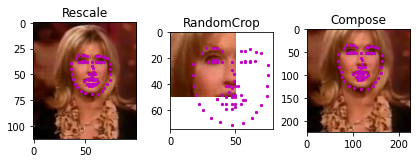

In [20]:
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

In [21]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/training_frames_keypoints.csv',
                                             root_dir='drive/My Drive/face/data/training/',
                                             transform=data_transform)

In [22]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Define the network Architecture

1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

In [23]:
## Define the network Architecture

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers 
        self.conv_1 = nn.Conv2d(1, 32, 4)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.conv_3 = nn.Conv2d(64, 128, 2)
        self.conv_4 = nn.Conv2d(128, 256, 1)

        # Maxpooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout (for all)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_6 = nn.Dropout(0.6)

        # Fully Connected Layer 
        self.fc_1 = nn.Linear(in_features = 43264, out_features = 1000) #torch.Size([10, 36864]) => in_features:  = 36864
        self.fc_2 = nn.Linear(in_features = 1000, out_features =  1000)
        self.fc_3 = nn.Linear(in_features =  1000, out_features =   136) 

    def forward(self, x):
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))

        x = self.drop_1(self.pool(F.relu(self.conv_1(x))))
        x = self.drop_2(self.pool(F.relu(self.conv_2(x))))
        x = self.drop_3(self.pool(F.relu(self.conv_3(x))))
        x = self.drop_4(self.pool(F.relu(self.conv_4(x))))

        # Flattening the layer
        x = x.view(x.size(0), -1)

        # print("in_features size: ", x.size(1))

        x = self.drop_5(F.relu(self.fc_1(x)))
        x = self.drop_6(F.relu(self.fc_2(x)))
        x = self.fc_3(x)

        # a modified x, having gone through all the layers of your model, should be returned
        return x

In [24]:
net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv_4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_1): Dropout(p=0.1, inplace=False)
  (drop_2): Dropout(p=0.2, inplace=False)
  (drop_3): Dropout(p=0.3, inplace=False)
  (drop_4): Dropout(p=0.4, inplace=False)
  (drop_5): Dropout(p=0.5, inplace=False)
  (drop_6): Dropout(p=0.6, inplace=False)
  (fc_1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc_3): Linear(in_features=1000, out_features=136, bias=True)
)


In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

In [25]:
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

### Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [26]:
batch_size = 10

train_loader = DataLoader(transformed_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

### Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [31]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/test_frames_keypoints.csv',
                                             root_dir='drive/My Drive/face/data/test/',
                                             transform=data_transform)

In [32]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on Test Sample

1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [33]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [34]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images1, test_outputs1, gt_pts1 = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images1.data.size())
print(test_outputs1.data.size())
print(gt_pts1.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

In [35]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

In [38]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

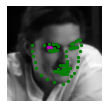

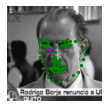

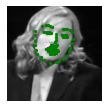

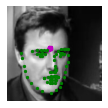

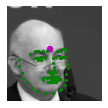

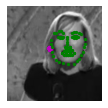

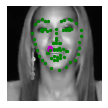

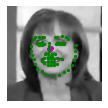

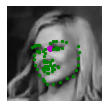

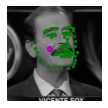

In [39]:
# call it

visualize_output(test_images1, test_outputs1, gt_pts1)

## Training

In [40]:
# Define the loss and optimization

import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001) 
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.999)

In [43]:
def train_net(n_epochs):

    # prepare the net for training

    net.train()

    for epochs in range(n_epochs):

      running_loss = 0.0

      # train on batches of data, assumes you already have train_loader
      for batch_i, data in enumerate(train_loader):

          # get the input images and their corresponding labels
          images = data['image']
          key_pts = data['keypoints']

          # flatten pts 
          key_pts = key_pts.view(key_pts.size(0), -1)

          # convert variables to floats for regression loss 
          key_pts = key_pts.type(torch.FloatTensor)
          images = images.type(torch.FloatTensor)

          # forward pass to get outputs
          output_pts = net(images)

          # calculate the loss between predicted and target keypoints 
          loss = criterion(output_pts, key_pts)

          # zero the parameter (weight) gradients
          optimizer.zero_grad() 

          # backward pass to calculate the weight gradients
          loss.backward()

          # update weights 
          optimizer.step()

          # print loss statistics
          # to convert loss into a scalar and add it to the running_loss, use .item()
          running_loss += loss.item()
          if batch_i % 10 == 9:    # print every 10 batches
             print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
             running_loss = 0.0

          print('Finished Training')

In [ ]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)